In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load and preprocess the dataset
def preprocess(data):
    image = tf.cast(data['image'], tf.float32) / 127.5 - 1
    return image

In [3]:
# Load CIFAR-10 dataset
train_ds = tfds.load('cifar10', split='train')
train_ds = train_ds.map(preprocess).shuffle(10000).batch(64)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.DWWJJQ_3.0.2/cifar10-train.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/incomplete.DWWJJQ_3.0.2/cifar10-test.tfrecord*...:   0%|          …

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
# Define the U-Net model
def unet_conv_block(inputs, filters, kernel_size=3):
    x = tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(inputs)
    x = tf.keras.layers.Conv2D(filters, kernel_size, activation='relu', padding='same')(x)
    return x

In [5]:
def unet_model():
    inputs = tf.keras.layers.Input(shape=(32, 32, 3))

    # Encoder
    conv1 = unet_conv_block(inputs, 64)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = unet_conv_block(pool1, 128)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = unet_conv_block(pool2, 256)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bridge
    conv4 = unet_conv_block(pool3, 512)

    # Decoder
    up5 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv4)
    up5 = tf.keras.layers.concatenate([up5, conv3])
    conv5 = unet_conv_block(up5, 256)

    up6 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv5)
    up6 = tf.keras.layers.concatenate([up6, conv2])
    conv6 = unet_conv_block(up6, 128)

    up7 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv6)
    up7 = tf.keras.layers.concatenate([up7, conv1])
    conv7 = unet_conv_block(up7, 64)

    outputs = tf.keras.layers.Conv2D(3, 1, activation=None, padding='same')(conv7)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name = 'U-Net' )

model = unet_model()

In [6]:
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 32, 32, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 16, 16, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [7]:
# Define the diffusion process
num_timesteps = 500
betas = tf.linspace(0.0002, 0.04, num_timesteps)
alphas = 1.0 - betas
alphas_cumprod = tf.math.cumprod(alphas)

In [8]:
@tf.function
def forward_diffusion(x, t):
    noise = tf.random.normal(shape=x.shape)
    mean = tf.sqrt(tf.gather(alphas_cumprod, t))[:, tf.newaxis, tf.newaxis, tf.newaxis] * x
    var = 1.0 - tf.gather(alphas_cumprod, t)
    return mean + tf.sqrt(var)[:, tf.newaxis, tf.newaxis, tf.newaxis] * noise, noise

In [9]:
# Training loop
@tf.function
def train_step(images):
    t = tf.random.uniform(shape=[tf.shape(images)[0]], minval=0, maxval=num_timesteps, dtype=tf.int32)
    noisy_images, noise = forward_diffusion(images, t)

    with tf.GradientTape() as tape:
        predicted_noise = model(noisy_images, training=True)
        loss = tf.reduce_mean(tf.square(noise - predicted_noise))

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [11]:
# Sampling function
@tf.function
def sample(num_samples=1):
    x = tf.random.normal(shape=(num_samples, 32, 32, 3))
    for t in tf.range(num_timesteps - 1, -1, -1):
        z = tf.random.normal(shape=tf.shape(x)) if t > 0 else tf.zeros_like(x)
        predicted_noise = model(x, training=False)
        alpha = tf.gather(alphas, t)
        alpha_cumprod = tf.gather(alphas_cumprod, t)
        x = 1 / tf.sqrt(alpha) * (x - (1 - alpha) / tf.sqrt(1 - alpha_cumprod) * predicted_noise)
        x = x + tf.sqrt(tf.gather(betas, t)) * z     # sigma_t = sqrt(beta_t)
    return x

epoch = 1 started.
epoch = 2 started.
epoch = 3 started.
epoch = 4 started.
epoch = 5 started.
epoch = 6 started.
epoch = 7 started.
epoch = 8 started.
epoch = 9 started.
epoch = 10 started.
Epoch 10, Loss: 0.0394


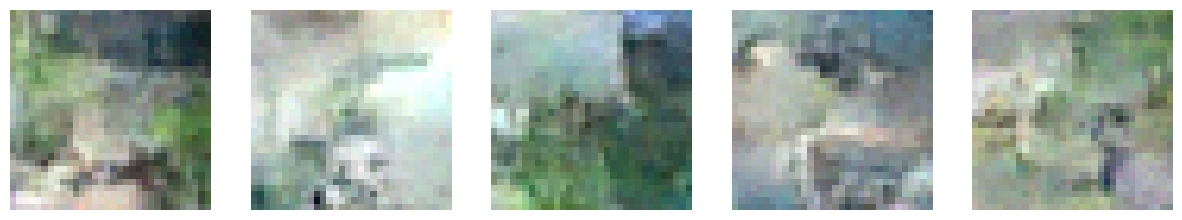

epoch = 11 started.
epoch = 12 started.
epoch = 13 started.
epoch = 14 started.
epoch = 15 started.
epoch = 16 started.
epoch = 17 started.
epoch = 18 started.
epoch = 19 started.
epoch = 20 started.
Epoch 20, Loss: 0.0376


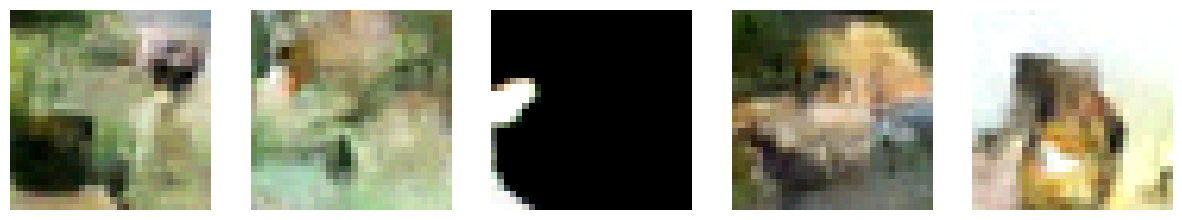

epoch = 21 started.
epoch = 22 started.
epoch = 23 started.
epoch = 24 started.
epoch = 25 started.
epoch = 26 started.
epoch = 27 started.
epoch = 28 started.
epoch = 29 started.
epoch = 30 started.
Epoch 30, Loss: 0.0361


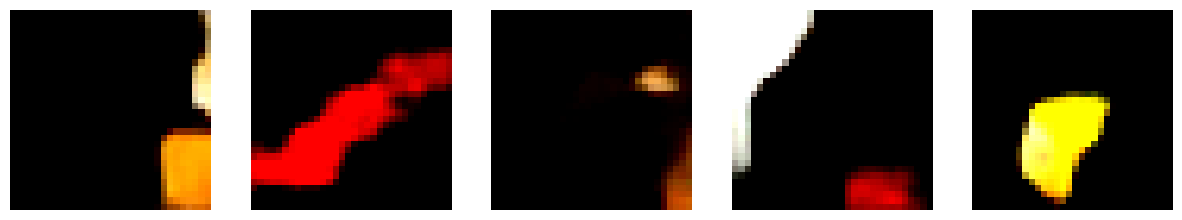

epoch = 31 started.
epoch = 32 started.
epoch = 33 started.
epoch = 34 started.
epoch = 35 started.
epoch = 36 started.
epoch = 37 started.
epoch = 38 started.
epoch = 39 started.
epoch = 40 started.
Epoch 40, Loss: 0.0354


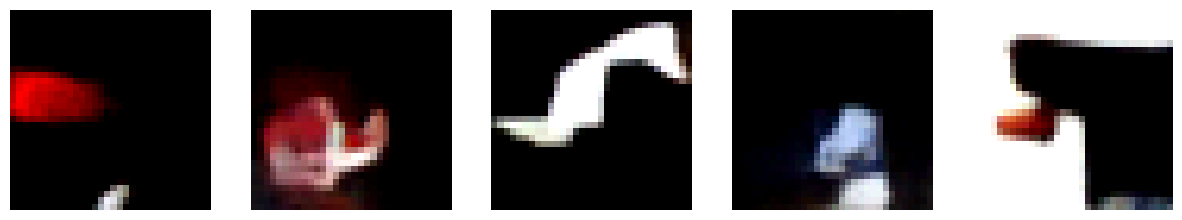

epoch = 41 started.
epoch = 42 started.
epoch = 43 started.
epoch = 44 started.
epoch = 45 started.
epoch = 46 started.
epoch = 47 started.
epoch = 48 started.
epoch = 49 started.
epoch = 50 started.
Epoch 50, Loss: 0.0349


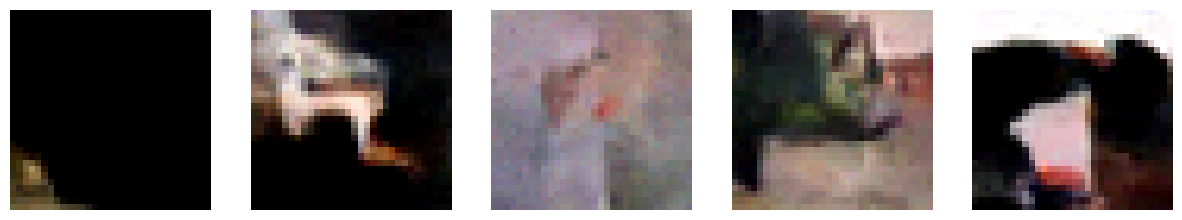

epoch = 51 started.
epoch = 52 started.
epoch = 53 started.
epoch = 54 started.
epoch = 55 started.
epoch = 56 started.
epoch = 57 started.
epoch = 58 started.
epoch = 59 started.
epoch = 60 started.
Epoch 60, Loss: 0.0348


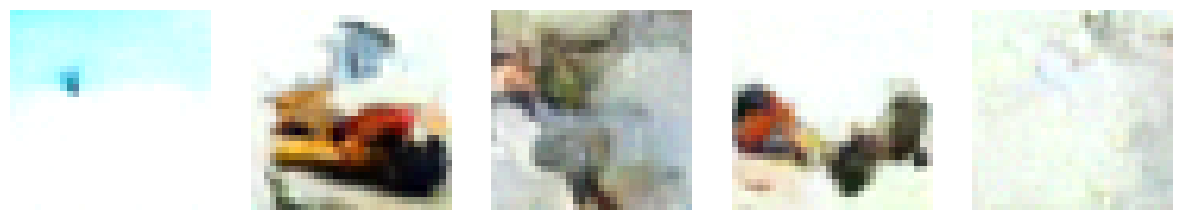

epoch = 61 started.
epoch = 62 started.
epoch = 63 started.
epoch = 64 started.
epoch = 65 started.
epoch = 66 started.
epoch = 67 started.
epoch = 68 started.
epoch = 69 started.
epoch = 70 started.
Epoch 70, Loss: 0.0350


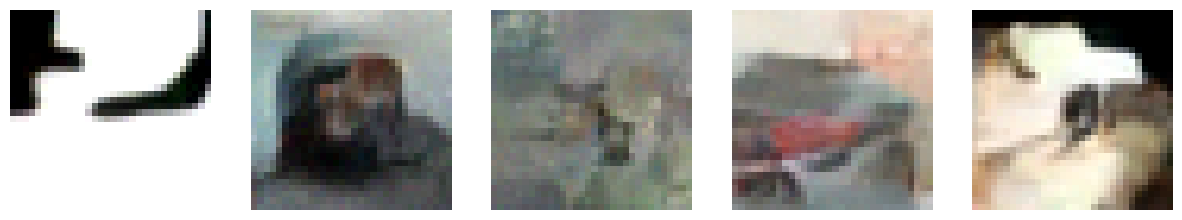

Training completed in 2604.965757369995 seconds


In [13]:
import time
# Training
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0004)
epochs = 70
loss_history = []

start = time.time()

for epoch in range(epochs):
    epoch_loss = []
    print(f"epoch = {epoch+1} started.")
    for images in train_ds:
        loss = train_step(images)
        epoch_loss.append(loss.numpy())

    avg_loss = np.mean(epoch_loss)
    loss_history.append(avg_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch + 1}, Loss: {avg_loss:.4f}")

        # Generate and display samples
        samples = sample(num_samples=5)
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        for i, ax in enumerate(axes):
            ax.imshow((samples[i].numpy() + 1) / 2)  # Rescale to [0, 1]
            ax.axis('off')
        plt.show()
print(f"Training completed in {time.time()-start} seconds")

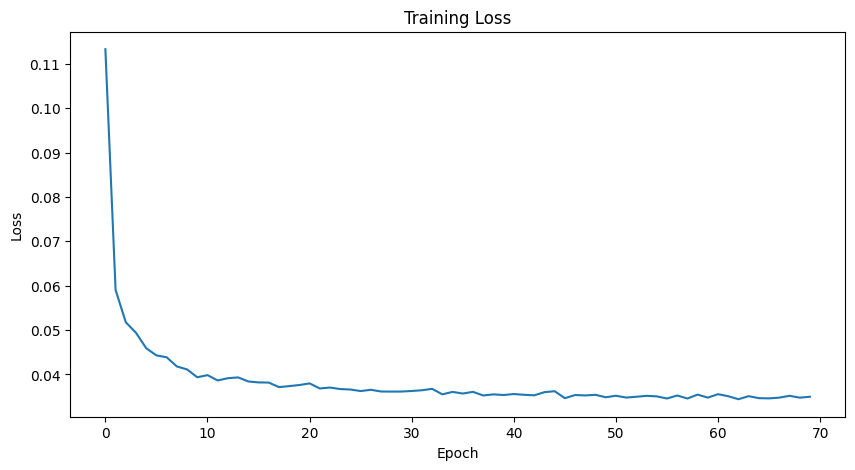

In [14]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [15]:
model.save("U-Net-TF-Diffusion-CIFAR10-2.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
